# Packages

In [1]:
import os
import sys
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms
import torchattacks
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from pytorchcv.model_provider import get_model as ptcv_get_model
device = "cuda"

/home/adl/anaconda3/envs/zenn/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Utility functions

### Denormalize function

In [61]:
def denorm(batch, mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]):
    if isinstance(mean, list):
        mean = torch.tensor(mean).to(batch.device)
    if isinstance(std, list):
        std = torch.tensor(std).to(batch.device)

    return batch * std.view(1, -1, 1, 1) + mean.view(1, -1, 1, 1)

### Get Cifar-100 classes

In [86]:
cifar100_classes =['Apple',
 'Aquarium_fish',
 'Baby',
 'Bear',
 'Beaver',
 'Bed',
 'Bee',
 'Beetle',
 'Bicycle',
 'Bottle',
 'Bowl',
 'Boy',
 'Bridge',
 'Bus',
 'Butterfly',
 'Camel',
 'Can',
 'Castle',
 'Caterpillar',
 'Cattle',
 'Chair',
 'Chimpanzee',
 'Clock',
 'Cloud',
 'Cockroach',
 'Couch',
 'Crab',
 'Crocodile',
 'Cup',
 'Dinosaur',
 'Dolphin',
 'Elephant',
 'Flatfish',
 'Forest',
 'Fox',
 'Girl',
 'Hamster',
 'House',
 'Kangaroo',
 'Keyboard',
 'Lamp',
 'Lawn_mower',
 'Leopard',
 'Lion',
 'Lizard',
 'Lobster',
 'Man',
 'Maple_tree',
 'Motorcycle',
 'Mountain',
 'Mouse',
 'Mushroom',
 'Oak_tree',
 'Orange',
 'Orchid',
 'Otter',
 'Palm_tree',
 'Pear',
 'Pickup_truck',
 'Pine_tree',
 'Plain',
 'Plate',
 'Poppy',
 'Porcupine',
 'Possum',
 'Rabbit',
 'Raccoon',
 'Ray',
 'Road',
 'Rocket',
 'Rose',
 'Sea',
 'Seal',
 'Shark',
 'Shrew',
 'Skunk',
 'Skyscraper',
 'Snail',
 'Snake',
 'Spider',
 'Squirrel',
 'Streetcar',
 'Sunflower',
 'Sweet_pepper',
 'Table',
 'Tank',
 'Telephone',
 'Television',
 'Tiger',
 'Tractor',
 'Train',
 'Trout',
 'Tulip',
 'Turtle',
 'Wardrobe',
 'Whale',
 'Willow_tree',
 'Wolf',
 'Woman',
 'Worm']

def get_cifar100_class(class_number):
    if class_number >= 0 and class_number < len(cifar100_classes):
        return cifar100_classes[class_number]
    else:
        return "Invalid class number"

# Load the dataset

### Load images

In [2]:
eval500_folder = "/home/adl/Desktop/zenn/SPML/HW2/eval_500"

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  
])
tensor_images = []
file_names = []
for filename in os.listdir(eval500_folder):
    if filename.endswith('.png'):  
        image_path = os.path.join(eval500_folder, filename)
        image = Image.open(image_path).convert('RGB')  
        tensor_image = transform(image).to(device)  
        tensor_images.append(tensor_image)  
        file_names+=[filename]
        

### Load labels

In [3]:
eval_labels = []
eval_labels_loaded = np.load('/home/adl/Desktop/zenn/SPML/HW2/labels_500.npy')
for i in range(len(eval_labels_loaded)):
    eval_labels.append(torch.tensor(eval_labels_loaded[i]).to(device))
print(eval_labels)

[tensor([46], device='cuda:0'), tensor([28], device='cuda:0'), tensor([80], device='cuda:0'), tensor([95], device='cuda:0'), tensor([15], device='cuda:0'), tensor([76], device='cuda:0'), tensor([98], device='cuda:0'), tensor([99], device='cuda:0'), tensor([65], device='cuda:0'), tensor([55], device='cuda:0'), tensor([83], device='cuda:0'), tensor([93], device='cuda:0'), tensor([29], device='cuda:0'), tensor([4], device='cuda:0'), tensor([54], device='cuda:0'), tensor([91], device='cuda:0'), tensor([34], device='cuda:0'), tensor([66], device='cuda:0'), tensor([62], device='cuda:0'), tensor([4], device='cuda:0'), tensor([95], device='cuda:0'), tensor([14], device='cuda:0'), tensor([76], device='cuda:0'), tensor([9], device='cuda:0'), tensor([17], device='cuda:0'), tensor([56], device='cuda:0'), tensor([15], device='cuda:0'), tensor([77], device='cuda:0'), tensor([95], device='cuda:0'), tensor([37], device='cuda:0'), tensor([86], device='cuda:0'), tensor([3], device='cuda:0'), tensor([5],

### Batches

In [56]:
batch_size = 64

batch_images = []
batch_labels = []
batch_targets = []
target = eval_labels[159]
target_labels = [target]*500

for i in range(0, len(tensor_images), batch_size):
    batch_images.append(torch.stack(tensor_images[i:i+batch_size]))
    batch_labels.append(torch.tensor(eval_labels[i:i+batch_size]))
    batch_targets.append(torch.tensor(target_labels[i:i+batch_size]))

# Models

In [32]:
models = []
model_names = ["resnet110", "preresnet164bn", "seresnet110", "densenet40_k36_bc", "diaresnet164bn"] 
for name,i in zip(model_names,range(10)):
   model = ptcv_get_model(f"{name}_cifar100", pretrained=True).to(device).eval()
   models.append(model)
      
class EnsembleModel(torch.nn.Module):
    def __init__(self, models):
        super(EnsembleModel, self).__init__()
        self.models = models

    def forward(self, x):
        # Get output from each model and average them
        outputs = [model(x) for model in self.models]
        avg_output = torch.mean(torch.stack(outputs), dim=0)
        return avg_output


class EnsembleModelEval(torch.nn.Module):
    def __init__(self, models):
        super(EnsembleModelEval, self).__init__()
        self.models = models

    def forward(self, x):
        # Get softmax output from each model
        softmax_outputs = [F.softmax(model(x), dim=1) for model in self.models]
        # Calculate the average softmax probabilities
        avg_softmax_output = torch.mean(torch.stack(softmax_outputs), dim=0)
        return avg_softmax_output
    
ensemble_model = EnsembleModel(models).to(device).eval()
ensemble_model_eval = EnsembleModelEval(models).to(device).eval()


# Check target image & label

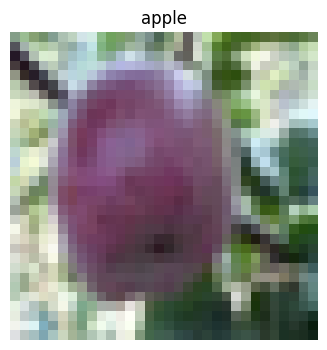

In [57]:
target_image = denorm(tensor_images[159])
target_image = transforms.ToPILImage()(target_image[0].squeeze())
plt.figure(figsize=(8,4)) 
plt.title(f'{get_cifar100_class(int(target))}')
plt.axis('off')
plt.imshow(target_image)

# Valina

In [70]:
correct = 0
total = 0

for images, labels in zip(batch_images, batch_labels):
    images = images.to(device)
    labels = labels.to(device)
    
    outputs = ensemble_model(images)
    preds = torch.argmax(outputs, dim=1)

    correct += (preds == labels).sum().item()
    total += labels.size(0)

accuracy = 100 * correct / total
print('Accuracy: {:.2f}%'.format(accuracy))


Accuracy: 99.00%


# Attack

In [16]:
adversarial_images = []
attack = torchattacks.PGD(ensemble_model, eps=4/255, alpha=1/510, steps=150, random_start=True)
attack.set_normalization_used(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
attack.set_mode_targeted_by_label()
attack.set_device(device)

success = 0 
total = 0
for images, labels, target in zip(batch_images, batch_labels, batch_targets ):
    images = images.to(device)
    images.requires_grad = True
    labels = labels.to(device)
    target = target.to(device)
    
    adv_images = attack(images, target)
    adversarial_images.append(adv_images)
    
# flatten adv_images
oneD_adv_images = []
for images_by_batch in adversarial_images:
    for img in images_by_batch:
        oneD_adv_images.append(img)

Failed to set device automatically, please try set_device() manual.
Attack mode is changed to 'targeted(label)'.


# Save adv_imgs

In [52]:
for adv_image,i in zip(oneD_adv_images,range(500)):
    denorm_adv_image = denorm(adv_image)
    perturbed_image = transforms.ToPILImage()(denorm_adv_image[0].squeeze())
    perturbed_image.save(f'/home/adl/Desktop/zenn/SPML/HW2/adv_imgs/{file_names[i]}', 'PNG')

# Test

### Load adv_images

In [59]:
adv_images_folder = "/home/adl/Desktop/zenn/SPML/HW2/adv_imgs"

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  
])
oneD_adv_images = []
for filename in os.listdir(adv_images_folder):
    if filename.endswith('.png'):  
        image_path = os.path.join(adv_images_folder, filename)
        image = Image.open(image_path).convert('RGB')  
        adv_image = transform(image).to(device)  
        oneD_adv_images.append(adv_image)  

batch_adv_images = []
for i in range(0, 500, batch_size):
        batch_adv_images.append(torch.stack(oneD_adv_images[i:i+batch_size]))
        

### Evaluate

In [84]:
success = [0]*6 
total = [0]*6
success_rate = [0]*6

ex_images_tensors = []
ex_adv_images_tensors = []
ex_labels_tensors = []
ex_preds_tensors = []

for images, adv_images, labels, target, x in zip(batch_images,batch_adv_images, batch_labels, batch_targets,range(len(batch_adv_images)) ):
    
    labels = labels.cuda() 
    target = target.cuda()
    
    # test on 5 models
    for model, i in zip(models,range(len(models))):
        outputs = model(adv_images)
        preds = torch.argmax(outputs, dim=1)
        
        success[i] += (preds == target).sum().item()
        total[i] += labels.size(0)
    
    # test on ensemble_model
    outputs = ensemble_model_eval(adv_images)
    preds = torch.argmax(outputs, dim=1)    
    success[5] += (preds == target).sum().item()
    total[5] += labels.size(0)
    
    # save some examples
    for x in range(2):
        if labels[x] != preds[x]:
            ex_images_tensors.append(images[x])
            ex_adv_images_tensors.append(adv_images[x])
            ex_labels_tensors.append(labels[x])
            ex_preds_tensors.append(preds[x])

for i in range(len(models)):
    success_rate[i] = 100 * success[i] / total[i]
    print(success[i],'|',total[i])
    print(model_names[i],'Success Rate:',success_rate[i],'%\n')
    
success_rate[5] = 100 * success[5] / total[5]
print(success[5],'|',total[5])
print('ensemble_model_eval Success Rate:',success_rate[5],'%\n')


429 | 500
resnet110 Success Rate: 85.8 %

455 | 500
preresnet164bn Success Rate: 91.0 %

378 | 500
seresnet110 Success Rate: 75.6 %

492 | 500
densenet40_k36_bc Success Rate: 98.4 %

392 | 500
diaresnet164bn Success Rate: 78.4 %

472 | 500
ensemble_model_eval Success Rate: 94.4 %



# Results

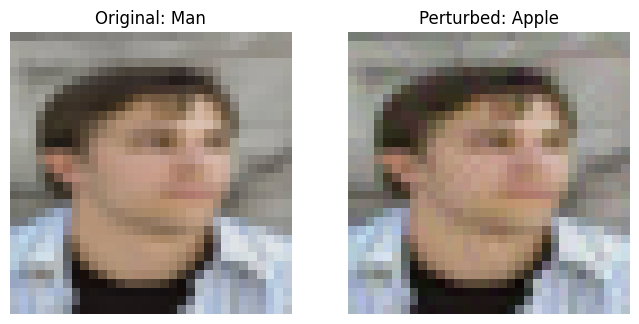

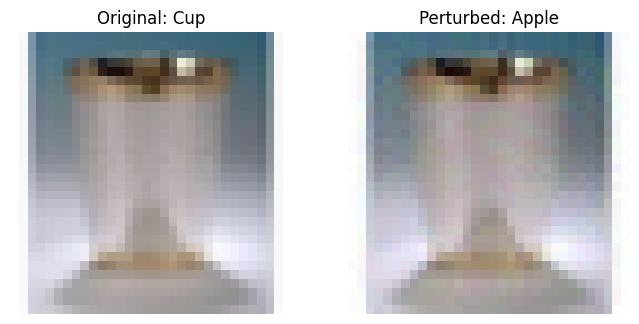

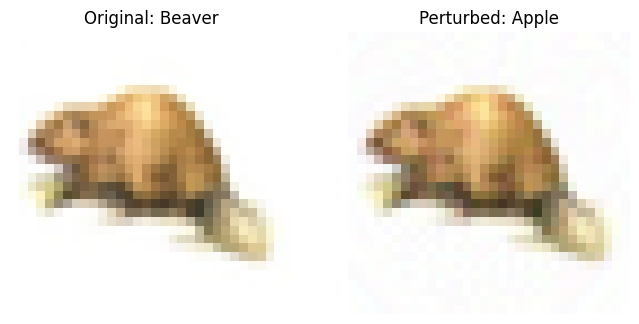

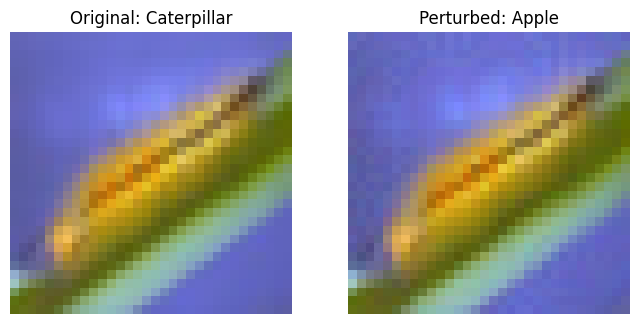

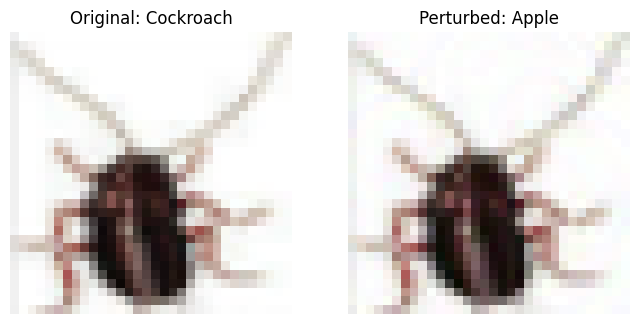

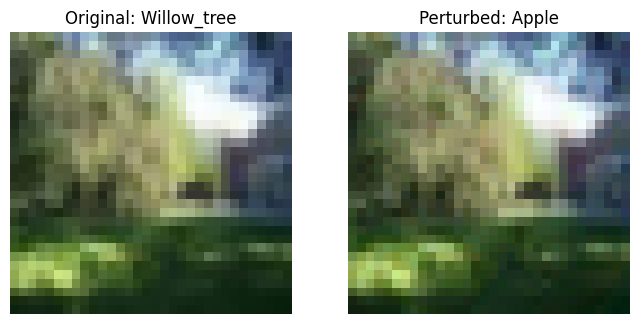

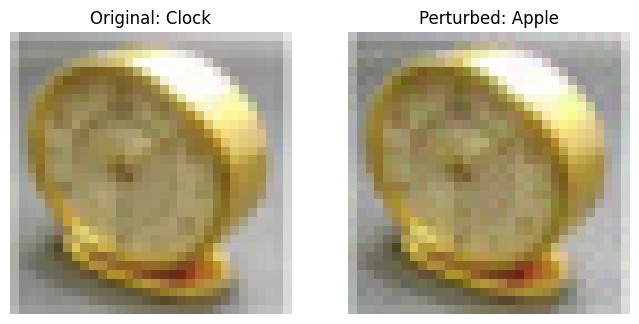

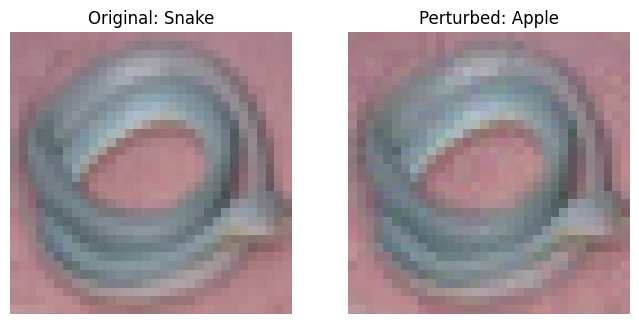

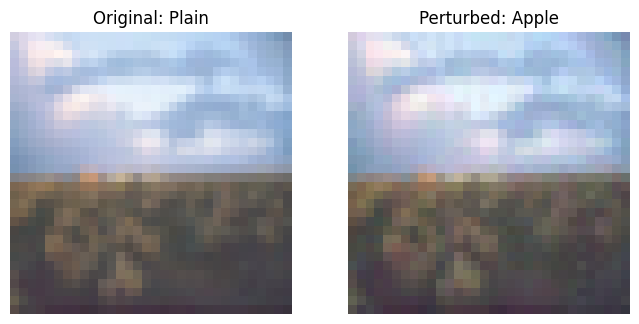

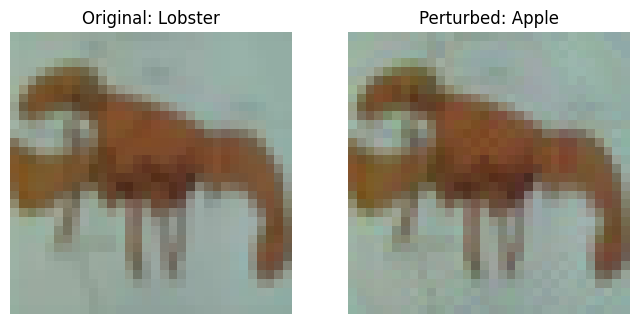

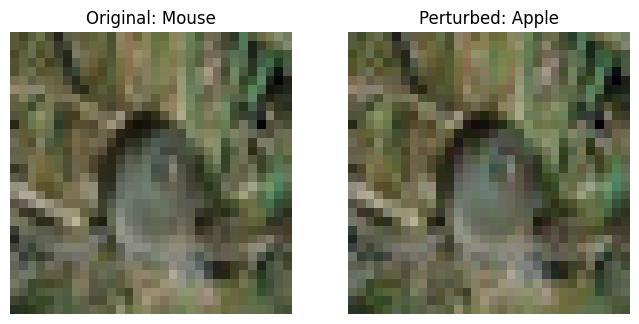

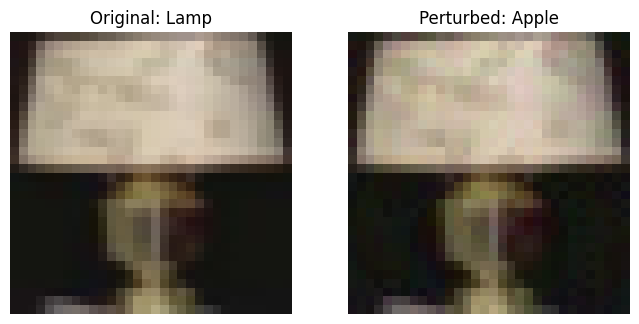

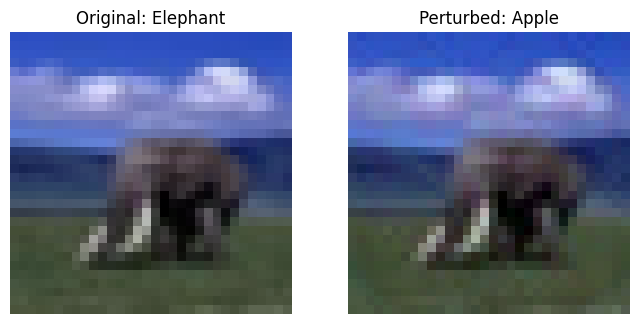

In [87]:
for ex_image_tensor, ex_adv_image_tensor,ex_label_tensor,ex_pred_tensor in zip(ex_images_tensors,ex_adv_images_tensors,ex_labels_tensors,ex_preds_tensors):
    denorm_ex_images_tensor = denorm(ex_image_tensor)
    ex_image = transforms.ToPILImage()(denorm_ex_images_tensor.squeeze())
    denorm_ex_adv_images_tensor = denorm(ex_adv_image_tensor)
    ex_adv_image = transforms.ToPILImage()(denorm_ex_adv_images_tensor.squeeze())
    ex_label = get_cifar100_class(int(ex_label_tensor))
    ex_pred = get_cifar100_class(int(ex_pred_tensor))
    plt.figure(figsize=(8,4)) 
    plt.subplot(121)
    plt.axis('off')
    plt.title(f'Original: {ex_label}')
    plt.imshow(ex_image)
    plt.subplot(122) 
    plt.axis('off')
    plt.title(f'Perturbed: {ex_pred}')
    plt.imshow(ex_adv_image)